<a href="https://colab.research.google.com/github/seonae0223/Deep_Learning/blob/main/03_MNIST_%ED%9D%91%EB%B0%B1_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import datasets, transforms
import torch

# 데이터 세트
train_ds = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_ds  = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

# 데이터 로더
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16086359.64it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 495179.23it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 924934.35it/s] 


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9749502.95it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# 데이터 로더에서 이미지를 1장만 로딩합니다.
images, labels = next(iter(train_dl))
images.shape

torch.Size([64, 1, 28, 28])

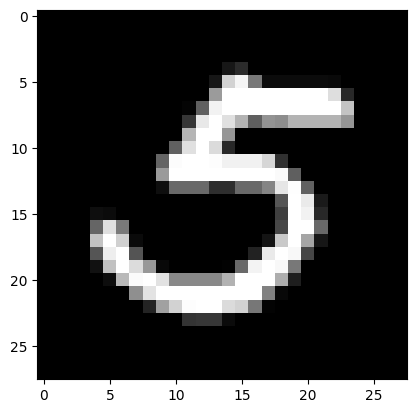

In [ ]:
# 첫 번째 이미지만 시각화 합니다.
import matplotlib.pyplot as plt
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()

# Conv 레이어 알아보기

In [ ]:
# 합성곱 레이어를 정의합니다. 필터는 3x3 필터 5개, padding도 1로 설정합니다.
import torch.nn as nn

conv_layer = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=1)

In [ ]:
# 이 레이어에 이미지를 통과 시킨 후 shape을 확인합니다.
conv_out = conv_layer(images[:1, ...])
conv_out.shape

torch.Size([1, 5, 28, 28])

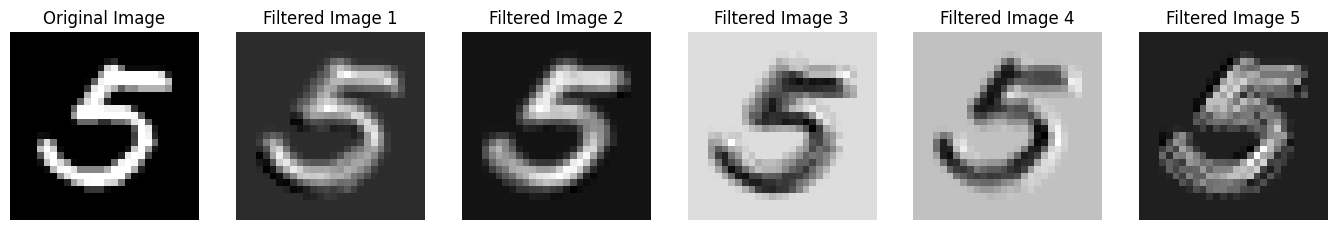

In [ ]:
# conv 레이어를 지나간 각 이미지를 시각화 합니다.
conv_out_images = conv_out[0]

fig, axes = plt.subplots(1, 6, figsize=(17, 3))

axes[0].imshow(images[0, ...].squeeze(), cmap='gray')
axes[0].title.set_text('Original Image')
axes[0].axis('off')

for idx, ax in enumerate(axes[1:]):
    ax.imshow(conv_out_images[idx, ...].detach().squeeze(), cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'Filtered Image {idx+1}')
plt.show()

# Filter 시각화

In [ ]:
filters = conv_layer.weight
filters.shape # (C_out, C_in, k_h, k_w)

torch.Size([5, 1, 3, 3])

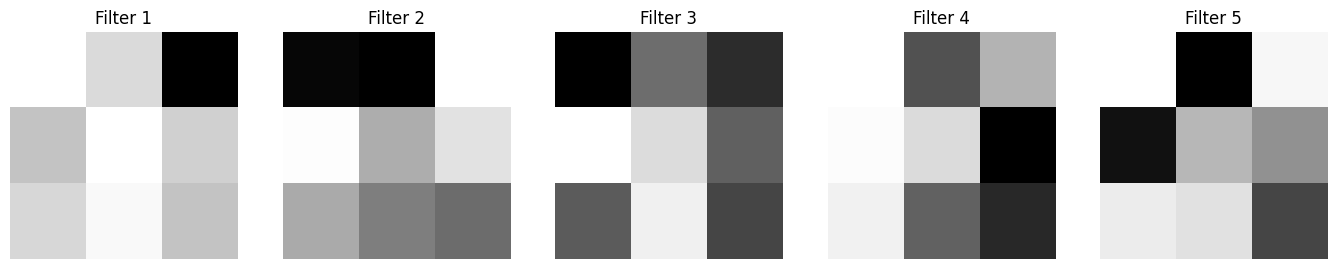

In [ ]:
# 시각화
fig, axes = plt.subplots(1, 5, figsize=(17, 3))

for idx, ax in enumerate(axes):
    ax.imshow(filters[idx, 0, ...].detach().squeeze(), cmap='gray')
    ax.title.set_text(f'Filter {idx+1}')
    ax.axis('off')
plt.show()

# ReLU 적용 후 시각화

In [ ]:
relu_layer = nn.ReLU()
relu_output = relu_layer(conv_out)
relu_output.shape

torch.Size([1, 5, 28, 28])

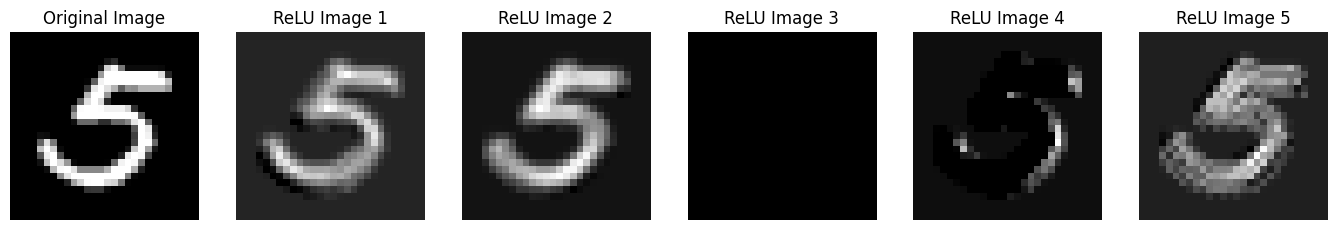

In [ ]:
relu_out_images = relu_output[0]

fig, axes = plt.subplots(1, 6, figsize=(17, 3))

axes[0].imshow(images[0, ...].squeeze(), cmap='gray')
axes[0].title.set_text('Original Image')
axes[0].axis('off')

for idx, ax in enumerate(axes[1:]):
    ax.imshow(relu_out_images[idx, ...].detach().squeeze(), cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'ReLU Image {idx+1}')
plt.show()

# MaxPooling 레이어 확인

In [ ]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_output = max_pool_layer(relu_output)
max_pool_output.shape

torch.Size([1, 5, 14, 14])

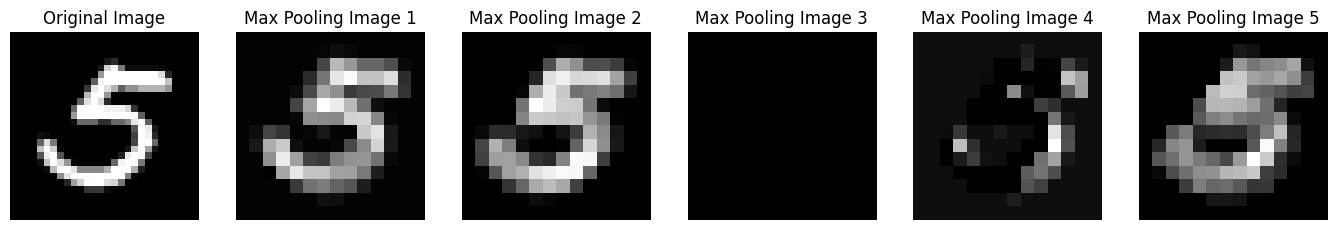

In [ ]:
max_pool_out_images = max_pool_output[0]

fig, axes = plt.subplots(1, 6, figsize=(17, 3))

axes[0].imshow(images[0, ...].squeeze(), cmap='gray')
axes[0].title.set_text('Original Image')
axes[0].axis('off')

for idx, ax in enumerate(axes[1:]):
    ax.imshow(max_pool_out_images[idx, ...].detach().squeeze(), cmap='gray')
    ax.axis('off')
    ax.title.set_text(f'Max Pooling Image {idx+1}')
plt.show()

# Flatten, GAP(Global Average Pooliing)을 활용한 평탄화

In [ ]:
# Flatten 레이어. 일반적으로 채널이 512개 이하인 경우 사용하면 좋다.
flatten_layer = nn.Flatten()
flatten_output = flatten_layer(max_pool_output)
flatten_output.shape

torch.Size([1, 980])

In [ ]:
# GAP(Global Average Pooling)을 수행할 때 사용한다. 채널이 512개 이상일 때 사용하면 좋다고 알려져 있다.
gap_layer = nn.AdaptiveAvgPool2d(output_size=1)
gap_output = gap_layer(relu_output)
gap_output = torch.flatten(gap_output, 1)
gap_output.shape

torch.Size([1, 5])

# Linear Layer를 이용한 FCN 구현

In [ ]:
linear_1 = nn.Linear(in_features=980, out_features=256)
linear_1_output = linear_1(flatten_output)
linear_1_output = nn.ReLU()(linear_1_output)
linear_1_output.shape

torch.Size([1, 256])

In [ ]:
linear_2 = nn.Linear(in_features=256, out_features=128)
linear_2_output = linear_2(linear_1_output)
linear_2_output = nn.ReLU()(linear_2_output)
linear_2_output.shape

torch.Size([1, 128])

In [ ]:
# 출력층
linear_3 = nn.Linear(in_features=128, out_features=10)
linear_3_output = linear_3(linear_2_output)
linear_3_output.shape

torch.Size([1, 10])

# CNN 분류 모델 만들기
- Conv 레이어를 이용해서 Feature Extraction
- Feature Extraction이 된 Feature Map을 이용해 추론하는 과정을 FCL로 구현

In [ ]:
from torch import nn

class Mnist_CNN(nn.Module):

  def __init__(self):
    super().__init__()

    # 흑백이미지가 들어가기 때문에 입력 채널을 1로 설정
    # 필터의 shape : (32, 1, 3, 3)

    ######## Feature Extraction #########
    self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    self.relu_1 = nn.ReLU()

    self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.relu_2 = nn.ReLU()

    self.max_pool_1 = nn.MaxPool2d(kernel_size=2)

    self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.relu_3 = nn.ReLU()

    self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.relu_4 = nn.ReLU()

    self.max_pool_2 = nn.MaxPool2d(kernel_size=2) # 여기 까지 오면 (N, 64, 7, 7)

    self.dropout = nn.Dropout(0.25)

    ######### Fully Conneceted Layer ########
    self.flatten = nn.Flatten() # 평탄화 시키면 (N, 64x7x7)

    self.linear_1 = nn.Linear(7*7*64, out_features=256)
    self.relu_5 = nn.ReLU()

    self.linear_2 = nn.Linear(256, 128)
    self.relu_6 = nn.ReLU()

    # 출력층
    self.out_layer = nn.Linear(128, 10)

  def forward(self, x):
    # Feature Extraction
    x = self.conv_1(x)
    x = self.relu_1(x)

    x = self.conv_2(x)
    x = self.relu_2(x)

    x = self.max_pool_1(x)

    x = self.conv_3(x)
    x = self.relu_3(x)

    x = self.conv_4(x)
    x = self.relu_4(x)

    x = self.max_pool_2(x)

    x = self.dropout(x)

    # FCL
    # 평탄화 부터
    x = self.flatten(x)

    x = self.linear_1(x)
    x = self.relu_5(x)

    x = self.linear_2(x)
    x = self.relu_6(x)

    y = self.out_layer(x)

    return y

# 모델 생성

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
model = Mnist_CNN().to(device)
model

Mnist_CNN(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=3136, out_features=256, bias=True)
  (relu_5): ReLU()
  (linear_2): Linear(in_features=256, out_features=128, bias=True)
  (relu_6): ReLU()
  (out_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size=(64, 1, 28, 28), device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
Mnist_CNN                                [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─ReLU: 1-2                              [64, 32, 28, 28]          --
├─Conv2d: 1-3                            [64, 32, 28, 28]          9,248
├─ReLU: 1-4                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-5                         [64, 32, 14, 14]          --
├─Conv2d: 1-6                            [64, 64, 14, 14]          18,496
├─ReLU: 1-7                              [64, 64, 14, 14]          --
├─Conv2d: 1-8                            [64, 64, 14, 14]          36,928
├─ReLU: 1-9                              [64, 64, 14, 14]          --
├─MaxPool2d: 1-10                        [64, 64, 7, 7]            --
├─Dropout: 1-11                          [64, 64, 7, 7]            --
├─Flatten: 1-12                          [64, 3136]                --
├─L

각 레이어의 파라미터 수는 다음 공식으로 계산됩니다:

	•	Conv2d 레이어: (출력 채널 수 × 입력 채널 수 × 커널 높이 × 커널 너비) + 출력 채널 수(바이어스)
	•	Linear 레이어: (입력 특징 수 × 출력 특징 수) + 출력 특징 수(바이어스)

이제 각 층별로 파라미터 수를 계산해보겠습니다.

1. Conv2d: 1-1

출력 형태: [64, 32, 28, 28]
파라미터 수: 320

	•	입력 채널 수: 1
	•	출력 채널 수: 32
	•	커널 크기: 3 × 3

계산:
(32 × 1 × 3 × 3) + 32 = 288 + 32 = 320

2. Conv2d: 1-3

출력 형태: [64, 32, 28, 28]
파라미터 수: 9,248

	•	입력 채널 수: 32
	•	출력 채널 수: 32
	•	커널 크기: 3 × 3

계산:
(32 × 32 × 3 × 3) + 32 = 9,216 + 32 = 9,248

3. Conv2d: 1-6

출력 형태: [64, 64, 14, 14]
파라미터 수: 18,496

	•	입력 채널 수: 32
	•	출력 채널 수: 64
	•	커널 크기: 3 × 3

계산:
(64 × 32 × 3 × 3) + 64 = 18,432 + 64 = 18,496

4. Conv2d: 1-8

출력 형태: [64, 64, 14, 14]
파라미터 수: 36,928

	•	입력 채널 수: 64
	•	출력 채널 수: 64
	•	커널 크기: 3 × 3

계산:
(64 × 64 × 3 × 3) + 64 = 36,864 + 64 = 36,928

5. Linear: 1-13

출력 형태: [64, 256]
파라미터 수: 803,072

	•	입력 특징 수: 64 × 7 × 7 = 3,136 (배치 크기는 제외)
	•	출력 특징 수: 256

계산:
(3,136 × 256) + 256 = 802,816 + 256 = 803,072

6. Linear: 1-15

출력 형태: [64, 128]
파라미터 수: 32,896

	•	입력 특징 수: 256
	•	출력 특징 수: 128

계산:
(256 × 128) + 128 = 32,768 + 128 = 32,896

7. Linear: 1-17

출력 형태: [64, 10]
파라미터 수: 1,290

	•	입력 특징 수: 128
	•	출력 특징 수: 10

계산:
(128 × 10) + 10 = 1,280 + 10 = 1,290

총 파라미터 수 검증

각 레이어의 파라미터 수를 모두 더하면:

320 + 9,248 + 18,496 + 36,928 + 803,072 + 32,896 + 1,290 = 902,250

# 훈련

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# 훈련 루프 정의
def train_loop(dataloader, model, loss_fn, optimizer):

  size = len(dataloader.dataset)

  # 모델을 훈련모드로 전환
  model.train()

  # 데이터 로더에서 데이터 꺼내기
  for batch, (X, y) in enumerate(dataloader):

    # 꺼낸 데이터를 gpu로 옮기기. 모델과 같은 디바이스 환경으로 설정
    X, y = X.to(device), y.to(device)

    # 예측 및 손실 계산
    pred = model(X)
    loss = loss_fn(pred, y)

    # 역전파 수행(미분)
    optimizer.zero_grad() # 이전 배치에서의 기울기를 제거
    loss.backward() # 역전파 수행
    optimizer.step() # 파라미터 갱신

    # 배치가 100번 돌 때마다 화면에 출력
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"Train Loss : {loss:>7f} [ {current:>5d} / {size:>5d} ]")

In [ ]:
# 추론 루프 정의
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)

  test_loss, correct = 0, 0
  model.eval() # 모델을 추론 모드로 설정

  # 추론 과정에서는 기울기를 구하지 않음. required_grad=False
  with torch.no_grad():

    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  num_batches = len(dataloader)

  # Loss와 Accuracy 평균 계산
  test_loss /= num_batches
  correct /= size

  print(f"Test Error : \n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")

In [ ]:
# 학습 수행
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n........................")
  train_loop(train_dl, model, loss_fn, optimizer)
  test_loop(test_dl, model, loss_fn)

print("Done!")

Epoch 1
........................
Train Loss : 2.303353 [     0 / 60000 ]
Train Loss : 0.627557 [  6400 / 60000 ]
Train Loss : 0.463111 [ 12800 / 60000 ]
Train Loss : 0.328080 [ 19200 / 60000 ]
Train Loss : 0.645359 [ 25600 / 60000 ]
Train Loss : 0.186018 [ 32000 / 60000 ]
Train Loss : 0.180013 [ 38400 / 60000 ]
Train Loss : 0.303312 [ 44800 / 60000 ]
Train Loss : 0.079950 [ 51200 / 60000 ]
Train Loss : 0.222836 [ 57600 / 60000 ]
Test Error : 
 Accuracy : 96.2%, Avg Loss : 0.129124

Epoch 2
........................
Train Loss : 0.247529 [     0 / 60000 ]
Train Loss : 0.204409 [  6400 / 60000 ]
Train Loss : 0.119430 [ 12800 / 60000 ]
Train Loss : 0.111494 [ 19200 / 60000 ]
Train Loss : 0.255266 [ 25600 / 60000 ]
Train Loss : 0.032537 [ 32000 / 60000 ]
Train Loss : 0.260141 [ 38400 / 60000 ]
Train Loss : 0.163846 [ 44800 / 60000 ]
Train Loss : 0.032789 [ 51200 / 60000 ]
Train Loss : 0.076410 [ 57600 / 60000 ]
Test Error : 
 Accuracy : 97.5%, Avg Loss : 0.076354

Epoch 3
..................

# Sequential을 이용해 반복되는 블록 묶어서 처리하기

In [ ]:
class Mnist_CNN_Sequential(nn.Module):
    def __init__(self):
        super().__init__()

        # Conv blocks
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
        )

        self.dropout = nn.Dropout(p=0.25)

        # FCN Block
        self.fcn_block = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=7 * 7 * 64, out_features=256),
          nn.ReLU(),
          nn.Linear(in_features=256, out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.dropout(x)
        out = self.fcn_block(x)
        return out

In [ ]:
model = Mnist_CNN_Sequential().to(device)
model

Mnist_CNN_Sequential(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fcn_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
# CrossEntropyLoss에 이미 소프트맥스 함수가 포함되어 있습니다.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# 학습 수행
epochs = 10
for t in range(epochs):
  print(f"Epoch {t+1}\n........................")
  train_loop(train_dl, model, loss_fn, optimizer)
  test_loop(test_dl, model, loss_fn)

print("Done!")

Epoch 1
........................


NameError: name 'train_loop' is not defined

In [ ]:
model.eval()
prediction = model(images.to(device))
prediction.shape

torch.Size([64, 10])

In [ ]:
def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(device)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)

    x_batch = x_batch.to("cpu")

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")

def im_plot(DL):
    x_batch, y_batch = next(iter(DL))
    plt.figure(figsize=(8,4))

    for idx in range(6):
        im = x_batch[idx]
        im = im-im.min() # for imshow clipping
        im = im/im.max() # for imshow clipping

        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(im.permute(1,2,0).squeeze())
        true_class = DL.dataset.classes[y_batch[idx]]
        plt.title(true_class, color = "g")
    print(f"x_batch size = {x_batch.shape}")

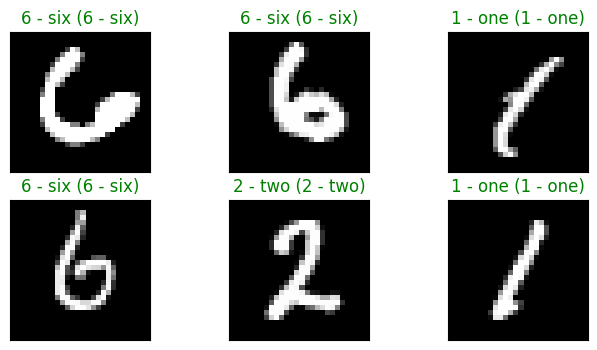

In [ ]:
Test_plot(model, test_dl)